In [1]:
import torch
import pandas as pd
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load processor and model
model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    attn_implementation="eager",
    output_attentions=True,
    return_dict=True
).to("cpu")

print("✅ Model & Processor Loaded!")

/opt/anaconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model & Processor Loaded!


In [2]:
# Load image
image_path = "image.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Prepare inputs
# prompt = "<image> What is the famous thing in the image?"
# prompt = processor.tokenizer.apply_chat_template([
#     {"role": "user", "content": "<image>", "add_generation_prompt": False},
#     {"role": "user", "content": "Who invented electricity?"}
# ], tokenize=False)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we have in the image?"}
        ]
    },
]

# ✅ Tokenize text prompt
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(images=[image], text=prompt, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# Decode output
generated_texts = processor.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)
print("📝 Generated Answer:", generated_texts[0])

📝 Generated Answer: QuestionQuestion

##The is you mean to common symbol? Theassistant

The


In [3]:
tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
cross_attn_layers = [3, 8, 13, 18, 23, 28, 33, 38]

# Locate start and end of question tokens
question_start = tokens.index("<|image|>") + 1
question_end = tokens.index("<|eot_id|>")
question_tokens = tokens[question_start:question_end]

# Output directory
output_dir = "./filtered_cross_attention_maps"
os.makedirs(output_dir, exist_ok=True)

# Loop over selected cross-attention layers
for layer in cross_attn_layers:
    cross_attn = outputs.attentions[layer][0]  # shape: [num_heads, text_seq_len, image_seq_len]
    attn_mean = cross_attn.mean(dim=0)         # shape: [text_seq_len, image_seq_len]

    # Filter only rows for question tokens
    question_attn = attn_mean[question_start:question_end]

    plt.figure(figsize=(12, 4))
    sns.heatmap(question_attn.cpu().numpy(), cmap="YlGnBu", annot=False)
    plt.title(f"Cross-Attention (Layer {layer}) — Question Tokens Only")
    plt.xlabel("Image Patches")
    plt.ylabel("Question Tokens")
    plt.yticks(ticks=range(len(question_tokens)), labels=question_tokens, rotation=0)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/question_cross_attention_layer_{layer}.png")
    plt.close()

In [ ]:
cross_attn_layers = [3, 8, 13, 18, 23, 28, 33, 38]

# Get token strings
tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

# Create directory to store maps
output_dir = "./cross_attention_maps"
os.makedirs(output_dir, exist_ok=True)

# Visualize cross-attention
for layer in cross_attn_layers:
    cross_attn = outputs.attentions[layer][0]  # shape: [num_heads, text_seq_len, image_seq_len]
    attn_mean = cross_attn.mean(dim=0)         # [text_seq_len, image_seq_len]

    plt.figure(figsize=(10, 6))
    sns.heatmap(attn_mean.numpy(), cmap="YlGnBu", annot=False)
    plt.title(f"Cross-Attention: Text Tokens → Image Embeddings (Layer {layer})")
    plt.xlabel("Image Patches")
    plt.ylabel("Text Tokens")
    plt.yticks(ticks=range(len(tokens)), labels=tokens, rotation=0)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/cross_attention_layer_{layer}.png")
    plt.close()

In [ ]:
model

In [16]:
import os
from PIL import Image

# Create directory to save image patches
patch_output_dir = "./image_patches_14x14"
os.makedirs(patch_output_dir, exist_ok=True)

# Reload the image
image_path = "image.jpg"
image = Image.open(image_path).convert("RGB").resize((224, 224))

# Patch parameters
patch_size = 14
patch_count = 0

# Split and save patches
for row in range(0, 224, patch_size):
    for col in range(0, 224, patch_size):
        patch = image.crop((col, row, col + patch_size, row + patch_size))
        patch.save(os.path.join(patch_output_dir, f"patch_{patch_count:03d}.png"))
        patch_count += 1

import os
os.listdir(patch_output_dir)[:10] 

['patch_202.png',
 'patch_216.png',
 'patch_028.png',
 'patch_000.png',
 'patch_014.png',
 'patch_148.png',
 'patch_174.png',
 'patch_160.png',
 'patch_161.png',
 'patch_175.png']

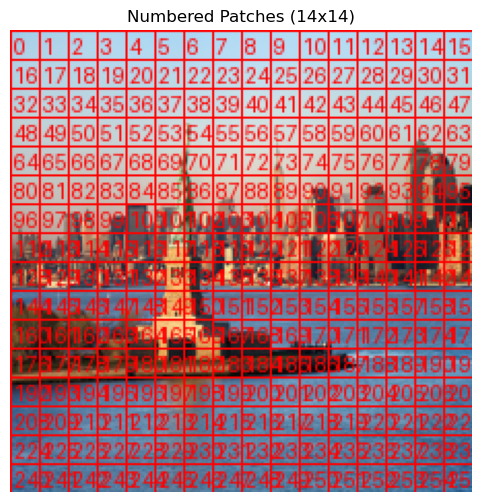

In [6]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load and resize image
image = Image.open("image.jpg").convert("RGB").resize((224, 224))
draw = ImageDraw.Draw(image)

patch_size = 14
patch_id = 0

# Try a default font
try:
    font = ImageFont.truetype("arial.ttf", 10)
except:
    font = ImageFont.load_default()

# Loop through patches and number them
for row in range(0, 224, patch_size):
    for col in range(0, 224, patch_size):
        draw.rectangle([col, row, col+patch_size, row+patch_size], outline="red", width=1)
        draw.text((col+2, row+2), str(patch_id), fill="red", font=font)
        patch_id += 1

# Show image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Numbered Patches (14x14)")
plt.show()

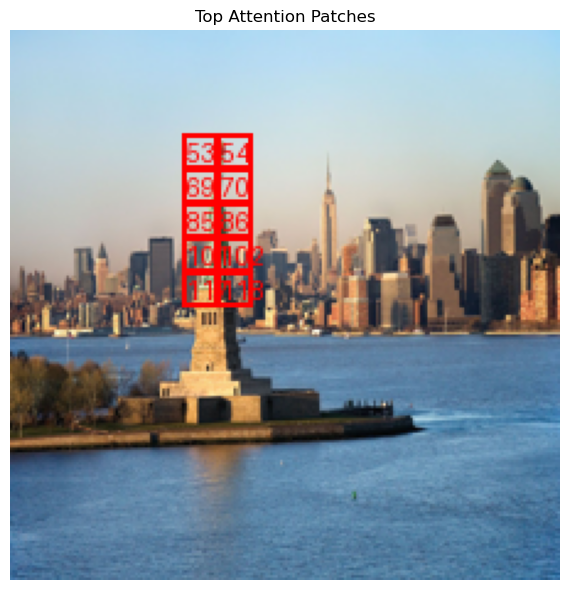

In [3]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load and resize image
image = Image.open("image.jpg").convert("RGB").resize((224, 224))
draw = ImageDraw.Draw(image)

# Assume 14x14 patch size → 16×16 grid → 256 total patches
patch_size = 14
top_attended_patch_ids = [85,86,69,70,53,54,101,102,117,118]  # Replace with your actual patch indices

# Draw rectangles around top patches
patch_id = 0
for row in range(0, 224, patch_size):
    for col in range(0, 224, patch_size):
        if patch_id in top_attended_patch_ids:
            draw.rectangle([col, row, col + patch_size, row + patch_size], outline="red", width=2)
            draw.text((col + 2, row + 2), str(patch_id), fill="red")
        patch_id += 1

# Show result
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Top Attention Patches")
plt.tight_layout()
plt.show()


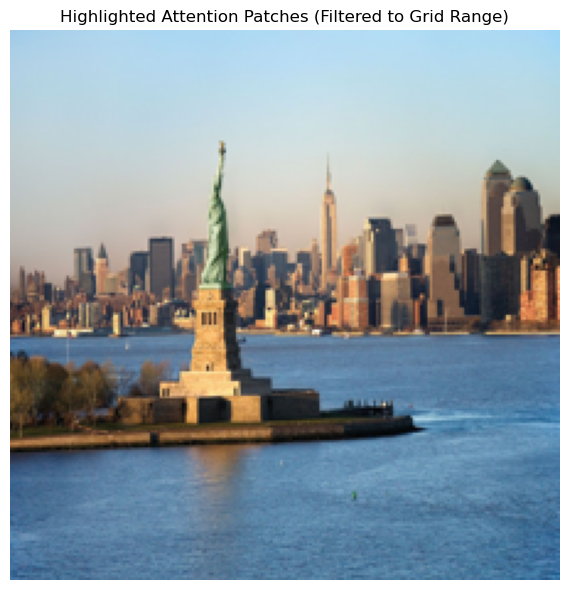

In [14]:
# Re-run necessary imports and logic after environment reset

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Reload and resize image
image_path = "image.jpg"
image = Image.open(image_path).convert("RGB").resize((224, 224))
draw = ImageDraw.Draw(image)

# Patches to highlight
highlight_patch_ids = [3358, 3504, 3560, 3796, 3942]

# Only show patches that fall within the 0–255 range for 16x16 grid
visible_patch_ids = [i for i in highlight_patch_ids if i < 256]

# Draw patch boundaries
patch_size = 14
patch_id = 0
for row in range(0, 224, patch_size):
    for col in range(0, 224, patch_size):
        if patch_id in visible_patch_ids:
            draw.rectangle([col, row, col + patch_size, row + patch_size], outline="red", width=2)
            draw.text((col + 2, row + 2), str(patch_id), fill="red")
        patch_id += 1

# Show the result
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title("Highlighted Attention Patches (Filtered to Grid Range)")
plt.tight_layout()
plt.show()